In [1]:
from functions.conv1fxn import *
from functions.functions_image_training import *
import tensorflow as tf
import timeit
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
%matplotlib inline

//anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [23]:
############### INPUTS: including bacth size, list of tuples and image dictionary###########################
mainfolder = 'images/quality_confirmed/'
rejects = 'images/rejects/'
batch_size = 30
epochs = 1
single_input_shape = (450,450,3)
validation_proportion = 0.1

In [24]:
img_dict, cat_list = classifier_folder_to_jpg_dict_list(mainfolder,rejects)
list_of_tuples = cat_list_to_list_of_tuples(img_dict, cat_list)
total_num = len(list_of_tuples)
classes = len(img_dict)
target_height,target_width,target_depth = single_input_shape
start_of_training = int(validation_proportion*total_num)
random.shuffle(list_of_tuples)
validation_list_of_tuples = list_of_tuples[:start_of_training]
training_list_of_tuples = list_of_tuples[start_of_training:]
num_val = len(validation_list_of_tuples)
num_train = len(training_list_of_tuples)
num_steps = int(num_train / batch_size)

#Sherlock does not allow jpg to numpy conversion after tensorflow has been started up

In [38]:
################ TENSOR FLOW #########################################
### TF variables #####################################################
tensor_image = tf.placeholder("uint8", [None, None, 3])

############ Manipulations to tensors in TF variables ########################
#### Resizing tesors #################################################################
resized_image = tf.image.resize_images(tensor_image, target_height, target_width)

######## Manipulations to resized tensors in Resizing tensors ####################
lrflip_resized = tf.image.flip_left_right(resized_image)
udflip_resized = tf.image.flip_up_down(resized_image)

####### BUILD NEURAL NET ARCHITECTURE ########################################
x = tf.placeholder(tf.float32, shape=[None, target_height,target_width,target_depth])
y_ = tf.placeholder(tf.float32, shape=[None, classes])

W_conv1 = weight_variable([10, 10, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
print('h_conv1 shape', h_conv1.get_shape().as_list())
h_pool1 = max_pool_2x2(h_conv1)
print('h_pool1 shape', h_pool1.get_shape().as_list())

W_conv2 = weight_variable([5, 5, 24, 21])
b_conv2 = bias_variable([21])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
print('h_conv2 shape', h_conv2.get_shape().as_list())

W_conv3 = weight_variable([5, 5, 21, 18])
b_conv3 = bias_variable([18])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3) + b_conv3)

h_conv3_shape =  h_conv3.get_shape().as_list()
print('h_conv3_shape', h_conv3_shape)

W_fc1 = weight_variable([h_conv3_shape[1] * h_conv3_shape[2] * h_conv3_shape[3], 128])
b_fc1 = bias_variable([128])

# reshape x to 4d tensor[-1,width,height,depth, channels]
h_conv3_flat = tf.reshape(h_conv3, [-1, h_conv3_shape[1] * h_conv3_shape[2] * h_conv3_shape[3]])
print('h_conv3_flat shape', h_conv3_flat.get_shape().as_list())
h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)

# probability that a neuron's output is kept during dropout
keep_prob = tf.placeholder(tf.float32)

#dropout layer
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
print('h_fc1_drop shape', h_fc1_drop.get_shape().as_list())

W_fc2 = weight_variable([128, 64])
b_fc2 = bias_variable([64])

h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
print('h_fc2  shape', h_fc2 .get_shape().as_list())

W_fc3 = weight_variable([64, classes])
b_fc3 = bias_variable([classes])

#################### SOFTMAX layer ###############################
h_fc3_logits = tf.matmul(h_fc2, W_fc3) + b_fc3

y_soft=tf.nn.softmax(h_fc3_logits)
print('y_soft shape', y_soft.get_shape().as_list())

###################### REGULARIZATION ##############################
L2_reg_const = 1e-6

L2_reg = (tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(W_conv2) + tf.nn.l2_loss(W_conv3)
+ tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(W_fc3))

#DEFINE COST FXN as cross entropy loss
cross_entropy = -tf.reduce_sum(y_*tf.log(tf.clip_by_value(y_soft,1e-10,1.0)))  + L2_reg_const*L2_reg

#DEFINE OPTIMIZER Instance
#train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1e-4
learning_rate = tf.train.exponential_decay(starter_learning_rate,global_step,10,0.95,staircase=True)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy, global_step=global_step)
#evaluate accuracy as boolean
correct_prediction = tf.equal(tf.argmax(y_soft,1), tf.argmax(y_,1))
#evaluate accuracy as binary average
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


######## initialization class for session running ############################
model_and_variables = tf.initialize_all_variables()
print('session initialized variables')

h_conv1 shape [None, 221, 221, 24]
h_pool1 shape [None, 110, 110, 24]
h_conv2 shape [None, 53, 53, 21]
h_conv3_shape [None, 25, 25, 18]
h_conv3_flat shape [None, 11250]
h_fc1_drop shape [None, 128]
h_fc2  shape [None, 64]
y_soft shape [None, 3]
session initialized variables


In [36]:
with tf.Session() as session: 
############## INITIALIZE VARIABLES WITHIN THIS SESSION #############################   
    session.run(model_and_variables)
    
################ BUILD VALIDATION SET ##########################################
######## INITIALIZE VALIDATION SET ########################################################
    validation_labels = np.zeros((num_val,classes))
    validation_tensors = np.zeros((num_val,target_height,target_width,target_depth))
########## TRAINING LOOP #####################################################
    
    for v in range(num_val):
        
        validation_image = mpimg.imread(mainfolder + validation_list_of_tuples[v][1])
        croppad_image = tf.image.resize_image_with_crop_or_pad(validation_image, target_height, target_width)

        Cropped =session.run(croppad_image, feed_dict={tensor_image: validation_image})
        #plt.imshow(Cropped.astype('uint8'))
        #plt.show()
        #print(type(Cropped))
        validation_labels[v] =  validation_list_of_tuples[v][0]
        validation_tensors[v] = Cropped / 255# normalize pixels  

In [30]:
len(Resized_image[0])

450

In [39]:
start_time = timeit.default_timer()

################## START SESSION ###############################################
with tf.Session() as session: 
    
    saver = tf.train.Saver()
    saved_model = "models/QualMode620.ckpt"

    if os.path.isfile(saved_model):
        print('Found', saved_model)
        saver.restore(session, saved_model)
        print(saved_model, "Model restored.")
    else:
        print('No saved Model')
        
    best_val_acc = np.float32(1/classes)

############## INITIALIZE VARIABLES WITHIN THIS SESSION #############################   
    session.run(model_and_variables)
########## TRAINING LOOP #####################################################

########## NUMBER OF EPOCHS ##################################################
    for epoch in range(epochs):
        print('epoch', epoch, 'steps:', num_steps)
    ########## SHUFFLE TRAINING DATA BETWEEN EPOCHS #############################    
        random.shuffle(training_list_of_tuples)
    ########## ONE EPOCH #####################################################
        for step in range(num_steps):
            offset = (step * batch_size) % (num_train)
            start = offset
            end = offset + batch_size
            if num_train - end < batch_size:
                end += (num_train % batch_size) # last end is extended to end of training set

    ######## INITIALIZE TRAINING BATCH ########################################################

            training_labels = np.zeros((batch_size*6,classes))
            training_tensors = np.zeros((batch_size*6,target_height,target_width,target_depth))

    ####### USE 'start' and 'end' to build one BATCH #####################################
    ####### HERE ################################################################
            i=0
            for j in range(start,end):
                
                ############ jpg to numpy at list element j ##################
                cycle_image = mpimg.imread(mainfolder + training_list_of_tuples[j][1])
                #plt.imshow(cycle_image)
                #plt.show()
                # j is the id for the image in this randomized dataset 
                ############ Tensor image fitting and augmentations #####################
                
                croppad_image = tf.image.resize_image_with_crop_or_pad(cycle_image, target_height, target_width)
                lrflip_croppad = tf.image.flip_left_right(croppad_image)
                udflip_croppad = tf.image.flip_up_down(croppad_image)
                
                graph_output=[resized_image,lrflip_resized,udflip_resized,croppad_image,lrflip_croppad,udflip_croppad]
                #session_output=[Resized_image,Lrflip_resized,Udflip_resized,Croppad_image,Lrflip_croppad,Udflip_croppad]
                
                session_output=session.run(graph_output,                                                        
                feed_dict={tensor_image: cycle_image})
                
                extended_batch_size = len(graph_output)
                
                for output in session_output:

                    training_labels[i] =  training_list_of_tuples[j][0]
                    training_tensors[i] = output/255 # normalize pixels 

                    i+=1
########### FEED TRAINING BATCH TO NETWORK ##########################################
########### HERE ####################################################################

            train_batch,Loss = session.run([train_step,cross_entropy],
                               feed_dict={x: training_tensors, y_: training_labels, keep_prob: 1.0})
    
            print('finished step ', step, 'learning rate' ,learning_rate.eval(), 'Loss:',Loss)
            print("max W vales: %g %g %g %g %g %g"%(tf.reduce_max(tf.abs(W_conv1)).eval(),
                                              tf.reduce_max(tf.abs(W_conv2)).eval(),tf.reduce_max(tf.abs(W_conv3)).eval(),
                                              tf.reduce_max(tf.abs(W_fc1)).eval(),tf.reduce_max(tf.abs(W_fc2)).eval(),
                                              tf.reduce_max(tf.abs(W_fc3)).eval()))

            print("max b vales: %g %g %g %g %g"%(tf.reduce_max(tf.abs(b_conv1)).eval(),tf.reduce_max(tf.abs(b_conv2)).eval(),
                                              tf.reduce_max(tf.abs(b_fc1)).eval(),tf.reduce_max(tf.abs(b_fc2)).eval(),
                                              tf.reduce_max(tf.abs(b_fc3)).eval())) 
            
            print("min W vales: %g %g %g %g %g %g"%(tf.reduce_min(tf.abs(W_conv1)).eval(),
                                              tf.reduce_min(tf.abs(W_conv2)).eval(),tf.reduce_min(tf.abs(W_conv3)).eval(),
                                              tf.reduce_min(tf.abs(W_fc1)).eval(),tf.reduce_min(tf.abs(W_fc2)).eval(),
                                              tf.reduce_min(tf.abs(W_fc3)).eval()))

            batch_acc = session.run(accuracy, feed_dict={x: training_tensors, y_: training_labels,  keep_prob: 1.0})
            print("batch accuracy: %g"% batch_acc)
            valid_acc = session.run(accuracy, feed_dict={x: validation_tensors, y_: validation_labels,  keep_prob: 1.0})
            print("Validation Accuracy: %g"% valid_acc)
            if valid_acc > best_val_acc:
                best_val_acc = valid_acc
                print('NEW best_val_acc')
                save_path = saver.save(session, saved_model)
                print("Model saved in file: %s" % save_path)
#######################################################################################

end_time = timeit.default_timer()
print('DONE, ran for %.2fm' % ((end_time - start_time) / 60.))

No saved Model
epoch 0 steps: 57
finished step  0 learning rate 0.0001 Loss: 1719.55
max W vales: 0.199883 0.199923 0.199987 0.20009 0.199948 0.196959
max b vales: 0.1001 0.1001 0.1001 0.1001 0.1001
min W vales: 3.29892e-07 2.5709e-05 7.51625e-06 7.1463e-08 4.40732e-06 0.000907025
batch accuracy: 0.3
Validation Accuracy: 0.363158
NEW best_val_acc
Model saved in file: models/QualMode620.ckpt
finished step  1 learning rate 0.0001 Loss: 1018.36
max W vales: 0.199813 0.200019 0.200087 0.200187 0.200048 0.196859
max b vales: 0.1002 0.1002 0.1002 0.1002 0.1002
min W vales: 1.48601e-05 1.78036e-06 1.13808e-05 7.1431e-08 4.40535e-06 0.000808284
batch accuracy: 0.322222
Validation Accuracy: 0.373684
NEW best_val_acc
Model saved in file: models/QualMode620.ckpt
finished step  2 learning rate 0.0001 Loss: 621.246
max W vales: 0.19973 0.200117 0.200184 0.200284 0.200122 0.196776
max b vales: 0.1003 0.100298 0.1003 0.100298 0.100297
min W vales: 2.07285e-05 1.01236e-05 2.11185e-06 7.13919e-08 2.294

KeyboardInterrupt: 

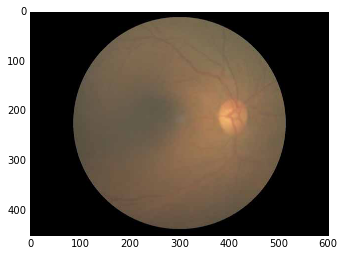

[ 0.  0.  1.]


In [20]:
c = training_list_of_tuples[2]
cycle_image = mpimg.imread(mainfolder + c[1])           
plt.imshow(cycle_image)
plt.show()
print(c[0])

[ 0.  0.  0.]


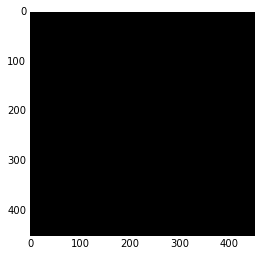

In [15]:
print(validation_labels[4])
plt.imshow(validation_tensors[4])
plt.show()

In [11]:
################## START SESSION ###############################################
with tf.Session() as session: 
    
    saver = tf.train.Saver()
    saved_model = "tf.argmax(Y_soft,1)"

    if os.path.isfile(saved_model):
        print('Found', saved_model)
        saver.restore(session, saved_model)
        print(saved_model, "Model restored.")
    else:
        print('No saved Model')
        
    best_val_acc = np.float32(1/classes)

############## INITIALIZE VARIABLES WITHIN THIS SESSION #############################   
    session.run(model_and_variables)
########## TRAINING LOOP #####################################################

    Y_soft=session.run([y_soft,],                                                        
    feed_dict={x: np.expand_dims(validation_tensors[0], axis=0) ,  keep_prob: 1.0})
    
print(Y_soft)


No saved Model
[array([[  2.48353019e-01,   1.79301889e-04,   7.51467645e-01]], dtype=float32)]
